In [1]:
from PIL import Image
import numpy as np
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
import matplotlib.pyplot as plt
from normxcorr2 import normxcorr2
import statistics 
import math

### Find offsets by beads file

In [2]:
#define find offset function for beads file
def find_offset(path):
    img = Image.open(path)
    images = []
    for i in range(img.n_frames):
        img.seek(i)
        images.append(np.array(img))
        beads = np.array(images)
    beadsavg=np.mean(beads, axis=0)
    #initialize offsets; cut the edge for donor(20) and acceptor(10) channels
    offsetx = 0
    offsety = 0
    donor = beadsavg[(20):int(beadsavg.shape[0]-20),(20):int(beadsavg.shape[1]/2-20)]
    acceptor = beadsavg[10:int(beadsavg.shape[0]-10),int(beadsavg.shape[1]/2+10):int(beadsavg.shape[1]-10)]
    #find cross correlation array, size should be D+A-1
    cc = normxcorr2(donor,acceptor)
    #output the offset values, since we expect donor locate in tbe middle of acceptor, so -10; +1 since python starts at 0
    offsetx = np.where(cc==np.max(cc))[1][0]-donor.shape[1]-10+1
    offsety = np.where(cc==np.max(cc))[0][0]-donor.shape[0]-10+1
    return print('x offset = '+str(offsetx)+' and y offset = '+str(offsety))

In [3]:
find_offset('Toxin/210608/beads_210608.tif')

x offset = 0 and y offset = 0


### Read data file

In [4]:
def read_tiff(path):
    img = Image.open(path)
    images = []
    for i in range(img.n_frames):
        img.seek(i)
        images.append(np.array(img))
    data = np.array(images) #outside the loop
    return data

In [5]:
data = read_tiff('Toxin/210608/Ch2_TcDA_SC_pH7_lp10_210608/Ch2_TcDA_SC_pH7_lp10_210608.tif')

### Subtract background noise with median values in both channels

In [6]:
def bg_subtraction(firstred, green, data):
    
    #getting mean values for all 500 green frames & last 50 red frames for background subtraction 
    green_data = data[firstred:firstred+green,:,:]
    red_data = data[firstred+green:,:,:]
    green_avg = np.mean(green_data, axis = 0).flatten()
    red_avg = np.mean(red_data, axis = 0).flatten()
    
    #getting mean for each channel individually 
    green_d = np.mean(green_data[:,:,:256], axis = 0).flatten()
    green_a = np.mean(green_data[:,:,256:], axis = 0).flatten()
    red_d = np.mean(red_data[:,:,:256], axis = 0).flatten()
    red_a = np.mean(red_data[:,:,256:], axis = 0).flatten()
    
    #locate the bin that has the most counts, since in each frame background pixels are the mojority 
    counts_g, bins_g = np.histogram(green_avg, bins=100)
    bg_threshold_g = math.ceil(bins_g[(np.where(counts_g==np.max(counts_g))[0][0]+1)])
    counts_r, bins_r = np.histogram(red_avg, bins=100)
    bg_threshold_r = math.ceil(bins_r[(np.where(counts_r==np.max(counts_r))[0][0]+1)]) #plus one bin to include outliers
    #bg_threshold_g, bg_threshold_r #below these value considered as bg pixels
    
    #background values for green & red excitation frames in both D/A channels
    greenbg_d = statistics.median(green_d[np.where(green_d<bg_threshold_g)])
    greenbg_a = statistics.median(green_a[np.where(green_a<bg_threshold_g)])
    redbg_d = statistics.median(red_d[np.where(red_d<bg_threshold_r)])
    redbg_a = statistics.median(red_a[np.where(red_a<bg_threshold_r)])
    

    #bg-subtraction
    r1_a = data[:firstred,:,256:512]-redbg_a
    g_a = data[firstred:firstred+green,:,256:512]-greenbg_a
    r2_a = data[firstred+green:,:,256:512]-redbg_a
    r1_d = data[:firstred,:,0:256]-redbg_d
    g_d = data[firstred:firstred+green,:,:256]-greenbg_d
    r2_d = data[firstred+green:,:,:256]-redbg_d
    
    acceptor = np.vstack((r1_a, g_a, r2_a))
    donor = np.vstack((r1_d, g_d, r2_d))
    data = np.dstack((donor,acceptor))
    
    return data

In [7]:
data = bg_subtraction(10, 500, data)

### Extract molecules from the mean of first 10 red frames

In [8]:
def locate_molecules(neighborhood_size, threshold, min_distance):
    
    firstred_avg= np.mean(data[:8,:,:],axis = 0)
    max_mask = filters.maximum_filter(firstred_avg, neighborhood_size)
    min_mask = filters.minimum_filter(firstred_avg, neighborhood_size)
    mole_map = (firstred_avg == max_mask)
    diff = ((max_mask - min_mask) > threshold)
    mole_map[diff == 0] = 0
    mole_map_A = mole_map[:,256:]
    #edgecut exclusion
    mole_map_A[:,:9] = False
    mole_map_A[:,-9:] = False
    mole_map_A[:9,:] = False
    mole_map_A[-9:,:] = False
    #mole_map_D = mole_map[:,:256]

    mole_coords = np.argwhere(mole_map_A == True)
    mole_coords_y = mole_coords[:,0]
    mole_coords_x = mole_coords[:,1]
    xx = np.tile(mole_coords_x,(len(mole_coords_x),1))
    xx_t = np.transpose(xx)
    yy = np.tile(mole_coords_y,(len(mole_coords_y),1))
    yy_t = np.transpose(yy)
    distance = (yy - yy_t)**2 + (xx - xx_t)**2
    overlap = np.argwhere((distance < min_distance**2) & (distance > 0)).flatten()
    overlap_n = np.array(list(set(overlap)))
    final_coords = np.delete(mole_coords,overlap_n,0)
    
    return [print('found this many molecules:' + str(final_coords.shape[0])), final_coords]

In [9]:
final_coords = locate_molecules(5,100,5)[1]

found this many molecules:109


### Calculate correlation coeff. for the A pixels the coresponded surrounding donor channel pixels

In [10]:
offsety = 0
offsetx = 0
A_map = np.zeros((512,256)).astype(bool)
D_map = np.zeros((512,256)).astype(bool)
A_map[final_coords[:,0],final_coords[:,1]] = True
D_map[final_coords[:,0] - offsety,final_coords[:,1] - offsetx] = True
D_coords = np.argwhere(D_map == True)

Acceptor = data[:,:,256:]
Donor = data[:,:,:256]
A_intensity = Acceptor[np.tile(A_map,(data.shape[0],1,1))].reshape(data.shape[0],-1)

D_area = [['D_tlmap','D_tmap','D_trmap'],['D_lmap','D_map','D_rmap'],['D_blmap','D_bmap','D_brmap']]
D_intensity = []
for i in range(0,3):
    for j in range(0,3):
        D_area[i][j] = np.zeros(D_map.shape).astype(bool)
        D_area[i][j][D_coords[:,0]+(i-1),D_coords[:,1]+(j-1)] = True
        D_ij = Donor[np.tile(D_area[i][j],(data.shape[0],1,1))].reshape(data.shape[0],-1)
        D_intensity.append(D_ij)
D_intensity = np.array(D_intensity)

In [11]:
A_intensity.shape, D_intensity.shape

((560, 109), (9, 560, 109))

In [12]:
# coeff. values of all the detected molecules in A channel and their corresponding molecule area pixels in D channel
# shape of 'coeffs' : No. molecules by 9
coeffs = []
for i in range(A_intensity.shape[1]):
    for j in range(9):
        rho = np.corrcoef(D_intensity[j,10:100,i],A_intensity[10:100,i])[0,1]
        coeffs.append(rho)
coeffs = np.array(coeffs).reshape(A_intensity.shape[1],-1)

In [13]:
# find the lowest coeff. along rows, i.e. the most anti-correlated values for each molecule
# 'min_coeffs': min values; shape of 'min_coeffs': No. molecules
min_coeffs = np.min(coeffs,axis=1)
# locate the lowest coeff. along rows
# this implies the most anti-correlated position within the molecule area in D channel 
# relative to the molecule pixel in A channel
# 'min_ind': indices of the min; shape of 'min_ind': No. molecules
min_ind = np.argmin(coeffs, axis=1)

# among all the lowest coeff. values, select out the molecules with the lowest coeff. below the thershold -0.5
# 'good_mole' is the indices of the molecules with lowest coeff. below threshold
good_mole_ind = np.argwhere(min_coeffs<-0.5)

# get the indices of the lowest coeff. for the molecules with the lowest coeff. below threshold
good_mole_D_ind = min_ind[good_mole_ind]

In [64]:
good_mole_ind.size

16

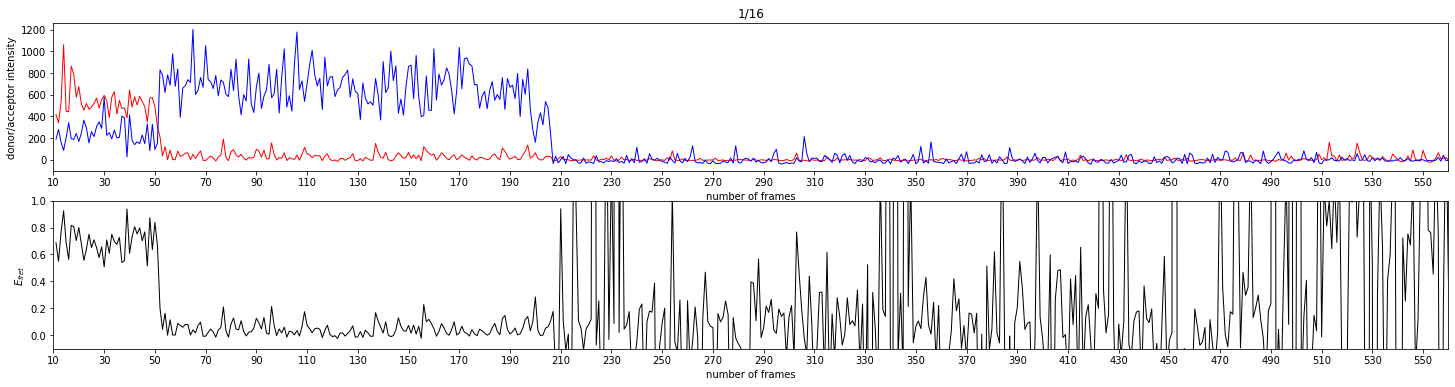

Save or not?s
At which frame the acceptor is bleached?51


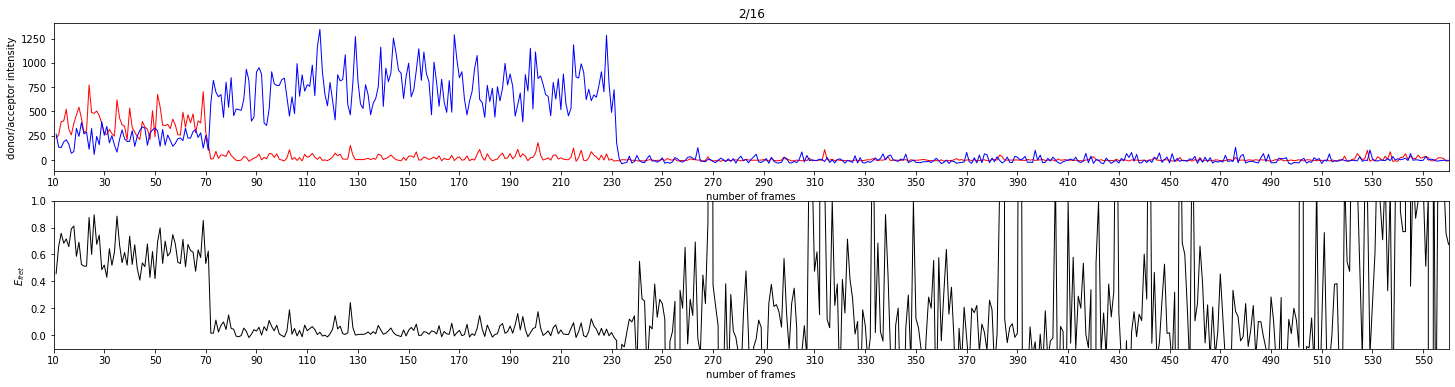

Save or not?s
At which frame the acceptor is bleached?70


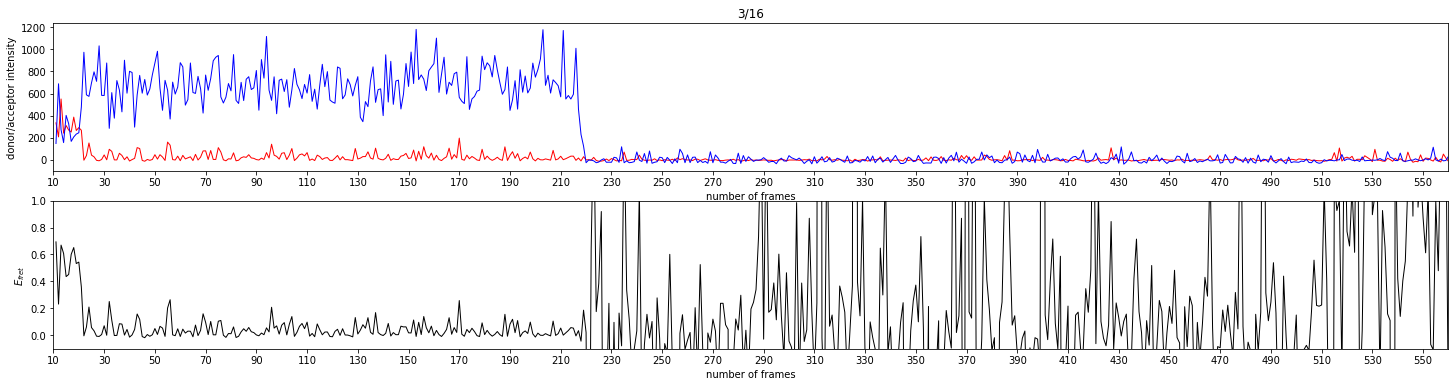

KeyboardInterrupt: Interrupted by user

In [60]:
x = np.linspace(11,A_intensity.shape[0],A_intensity.shape[0]-10)
loop = good_mole_ind.size
pw_fret = []
saved_traces = []

for i in range(loop):
    A = np.squeeze(A_intensity[:,good_mole_ind[i]])
    D = np.squeeze(D_intensity[good_mole_D_ind[i],:,good_mole_ind[i]])
    
    plt.figure(figsize=(25,6))
    ax1 = plt.subplot(211)
    plt.plot(x, A[10:],'r',linewidth=1)
    plt.plot(x, D[10:],'b',linewidth=1)
    plt.xlim(10,560)
    plt.xlabel('number of frames')
    plt.ylabel('donor/acceptor intensity')
    plt.xticks(np.arange(10, x.shape[0]+1, 20))
    plt.title(str(i+1)+'/'+str(loop))
    
    E_fret = A/(A+D)
    ax2 = plt.subplot(212)
    plt.plot(x,E_fret[10:],'k', linewidth=1)
    plt.xlim(10,560)
    plt.xlabel('number of frames')
    plt.ylim(-0.1,1)
    plt.ylabel('$E_{fret}$')
    plt.xticks(np.arange(10, x.shape[0]+1, 20))
    plt.show()
    
    save = input("Save or not?")
    if str(save)=='s':
        framenumber = int(input("At which frame the acceptor is bleached?"))
        pw_fret.append(E_fret[10:framenumber])
        saved_traces.append(D)
        saved_traces.append(A)

In [62]:
for i in range(len(pw_fret)):
    print(pw_fret[i].shape)
#pw_fret =  np.concatenate(pw_fret)

(41,)
(60,)


In [63]:
traces_p = []
for i in range(int(len(pruned_traces)/2)):
    frame_len = len(pruned_traces[2*i])
    intensity = np.array([np.ones(frame_len)*(i+1),pruned_traces[2*i],pruned_traces[2*i+1]])
    intensity = intensity.transpose()
    traces_p.append(intensity)
traces_p = np.concatenate(traces_p)
traces_p.shape

(393, 3)

#### change file names!!!

In [698]:
# pw_fret = np.concatenate(pw_fret)
# traces_s = np.array(saved_traces).transpose()
# np.savetxt('Toxin/210608/Ch2_TcDA_SC_pH7_lp10_210608/TcdA10_pwE.dat', pw_fret, fmt='%7.5f')
# np.savetxt('Toxin/210608/Ch2_TcDA_SC_pH7_lp10_210608/TcdA10_good.dat', traces_s, fmt='%8.1f')

In [62]:
traces_s = np.array(saved_traces).transpose()
np.array(saved_traces).shape,traces_s.shape

((0,), (0,))

### Edge detection in E_fret

In [22]:
good_mole_ind.shape, good_mole_D_ind.shape

((16, 1), (16, 1))

In [23]:
x = np.linspace(11,A_intensity.shape[0],A_intensity.shape[0]-10)
loop = good_mole_ind.size
pw_fret = []
saved_traces = []

for i in range(loop):
    A = np.squeeze(A_intensity[:,good_mole_ind[i]])
    D = np.squeeze(D_intensity[good_mole_D_ind[i],:,good_mole_ind[i]])
    E_fret = A/(A+D)

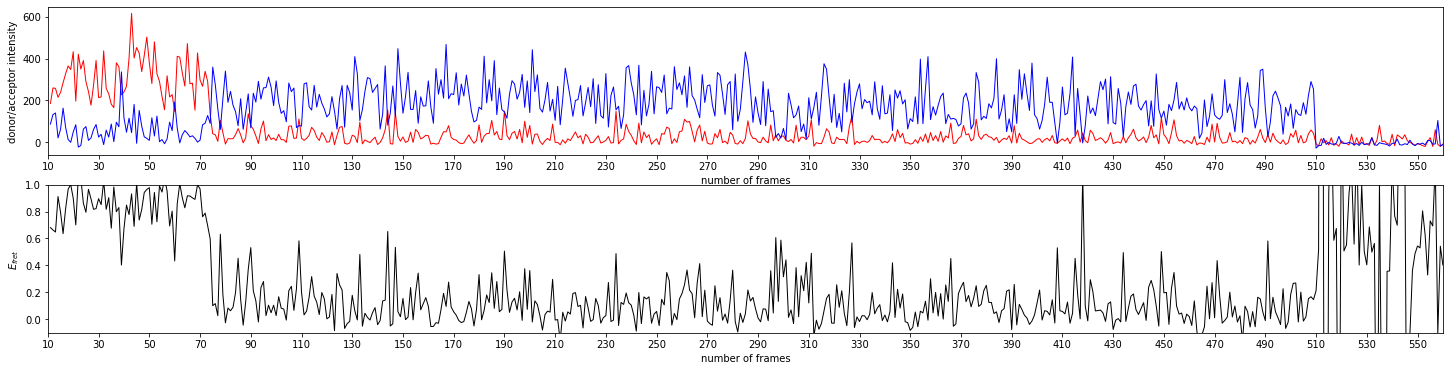

In [57]:
plt.figure(figsize=(25,6))
ax1 = plt.subplot(211)
plt.plot(x, A[10:],'r',linewidth=1)
plt.plot(x, D[10:],'b',linewidth=1)
plt.xlim(10,560)
plt.xlabel('number of frames')
plt.ylabel('donor/acceptor intensity')
plt.xticks(np.arange(10, x.shape[0]+1, 20))

ax2 = plt.subplot(212)
plt.plot(x,E_fret[10:],'k', linewidth=1)
plt.xlim(10,560)
plt.xlabel('number of frames')
plt.ylim(-0.1,1)
plt.ylabel('$E_{fret}$')
plt.xticks(np.arange(10, x.shape[0]+1, 20))
plt.show()


(-0.1, 1.0)

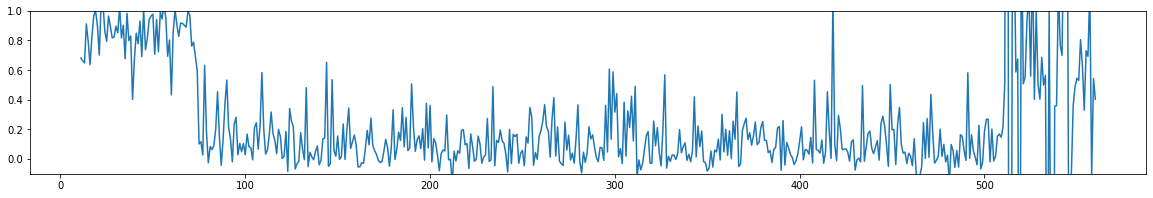

In [56]:
plt.figure(figsize=(20,3))
plt.plot(x,A[10:],D[10:])
plt.plot(x, E_fret[10:])
plt.ylim(-0.1,1)
# plt.xlim(10,560)
# grad = E_fret[10:508] - E_fret[11:509]
# np.max(grad[np.where(grad > 0)])
# np.where(grad == np.max(grad[np.where(grad>0)]))
# plt.

((246,), (498,))

##### Moving Avg. Method

In [61]:
E_fret.shape

(560,)